In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pygmt
from obspy.core import UTCDateTime

from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
import joblib
import os
import json

In [2]:
# Read in features, look at names & datatypes
df_original = pd.read_csv('p_features.csv', dtype={'location_code': str})
print(len(df_original))
print(df_original.dtypes)

72952
arrival_identifier                int64
avg_noise_1.00                  float64
avg_noise_10.00                 float64
avg_noise_11.00                 float64
avg_noise_12.00                 float64
avg_noise_13.00                 float64
avg_noise_14.00                 float64
avg_noise_15.00                 float64
avg_noise_16.00                 float64
avg_noise_17.00                 float64
avg_noise_18.00                 float64
avg_noise_2.00                  float64
avg_noise_3.00                  float64
avg_noise_4.00                  float64
avg_noise_5.00                  float64
avg_noise_6.00                  float64
avg_noise_7.00                  float64
avg_noise_8.00                  float64
avg_noise_9.00                  float64
avg_signal_1.00                 float64
avg_signal_10.00                float64
avg_signal_11.00                float64
avg_signal_12.00                float64
avg_signal_13.00                float64
avg_signal_14.00                fl

In [3]:
# Get metadata for 1 and 3c stations
eq_meta_onec = pd.read_csv("../currentEarthquakeArrivalInformation1CWithGains.csv")
eq_meta_threec = pd.read_csv("../currentEarthquakeArrivalInformation3CWithGains.csv")
eq_meta_all = pd.concat([eq_meta_onec, eq_meta_threec])

# Reduce to just location information
all_eq_locs = eq_meta_all.drop_duplicates("evid")[["evid", "event_lat", "event_lon", "origin_time"]]
all_eq_locs.columns = ["event_identifier", "event_lat", "event_lon", "origin_time"]

# Reduce to events in the dataset 
eq_locs_df = all_eq_locs[np.isin(all_eq_locs.event_identifier, df_original.event_identifier.unique())]
# Make date column for filtering
eq_locs_df.loc[:, "date"] = eq_locs_df.origin_time.apply(lambda x: int(UTCDateTime(x).strftime("%y%m%d")))

/tmp/ipykernel_13094/187499698.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  eq_meta_threec = pd.read_csv("../currentEarthquakeArrivalInformation3CWithGains.csv")
/tmp/ipykernel_13094/187499698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eq_locs_df.loc[:, "date"] = eq_locs_df.origin_time.apply(lambda x: int(UTCDateTime(x).strftime("%y%m%d")))


In [4]:
# Set filter bounds
lat_min = 44.680
lat_max = 44.870
lon_max = 110.850
lon_min = 110.640
date_min = 130901  # YYMMDD
date_max = 140630  # YYMMDD
bounds = {"lat_min": lat_min,
          "lat_max": lat_max,
          "lon_max": lon_max,
          "lon_min": lon_min,
          "date_min": date_min,
          "date_max": date_max}

# Get ngb event ids
ngb_event_locs = eq_locs_df.loc[
        (eq_locs_df["date"] >= bounds["date_min"]) & (eq_locs_df["date"] <= bounds["date_max"]) & (eq_locs_df["event_lat"] >= bounds["lat_min"])
        & (eq_locs_df["event_lat"] <= bounds["lat_max"]) & (-1 * eq_locs_df["event_lon"] >= bounds["lon_min"]) & (
                    -1 * eq_locs_df["event_lon"] <= bounds["lon_max"])]

In [5]:
df_ngb_removed = df_original[~np.isin(df_original.event_identifier, ngb_event_locs.event_identifier)]
df_ngb = df_original[np.isin(df_original.event_identifier, ngb_event_locs.event_identifier)]
np.where(np.isin(df_ngb_removed.event_identifier, df_ngb.event_identifier))

(array([], dtype=int64),)

In [6]:
# Keep stations with more than 350 observations (all together, including NGB)
stat_counts = df_original.value_counts("station").to_frame().reset_index()
stat_counts.columns = ["Station", "Count"]
stat_counts.to_csv("feature_station_counts.csv", index=False)
df_org_filtcounts = df_ngb_removed[np.isin(df_ngb_removed.station, stat_counts[stat_counts.Count >= 350])]
df_ngb_filtcounts = df_ngb[np.isin(df_ngb.station, stat_counts[stat_counts.Count >= 350])]

In [7]:
# Computes the feature matrix from a dataframe
def compute_feature_df(df, scaler=None, include_noise_var=False):
    # Loosely speaking empirical magnitudes look like:
    # M = log10(A) + Q(Delta) 
    # where A is the amplitude and Q a distance dependent correction term.
    # Additionally, the difference between log10 and log amounts to a scalar
    # that a machine can learn.
    # Basically, I'm interested in features that:
    #   (1) Measure size in, potentially, different amplitudes.
    # different `passbands' deviates from the noise, 
    n_rows = len(df)
    n_columns = 9
        
    X = np.zeros([n_rows, n_columns])
    # Get a proxy on size
    

#      ['amp_ratio_01.0', 'amp_02.0', 'signal_variance', 'noise_variance', 'noise_max_amplitude', 
#          'signal_max_amplitude', 'source_receiver_distance_logkm', 'source_depth_km','receiver_back_azimuth'] 
        
    # These are effectively amplitude ratios.  Note,
    # log(a/b) = log(a) - log(b)
    X[:,0]  = np.log(df['avg_signal_1.00']) - np.log(df['avg_noise_1.00'])
    # Look at amplitudes
    X[:,1] = np.log(df['avg_signal_2.00'])
    # Time-based featuers: Look at max amplitudes of noise/signal
    X[:,2] = np.log(df['signal_variance'])
    X[:,3] = np.log(df['noise_variance'])    
    X[:,4] = np.log(df['noise_maximum_value']  - df['noise_minimum_value'])
    X[:,5] = np.log(df['signal_maximum_value'] - df['signal_minimum_value'])
    # Source/recv distance (take log to flatten this)
    X[:,6] = np.log(df['source_receiver_distance_km'])
    X[:,7] = df['source_depth_km']
    # Single stations can learn location
    X[:,8] = df['source_receiver_back_azimuth']
    

    # Standardize features
    if (scaler is None):
        scaler = StandardScaler()
        scaler = scaler.fit(X)
    
    X = scaler.transform(X)
    return X, scaler

Working on station: YNR
3621 training examples - 80.37735849056604%
884 testing examples - 19.622641509433965%
SVR with all features:


/tmp/ipykernel_13094/3387332634.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_summary.loc[:, "predicted_magnitude"] = y_est
/tmp/ipykernel_13094/3387332634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ngb_summary.loc[:, "predicted_magnitude"] = ngb_est


Test MSE 0.04196267247217148
Test R2: 0.8554225375482263
Train MSE 0.031137981793710495
Train R2: 0.8997183260934305
512 NGB examples
NGB MSE 0.07689367113071634
NGB R2: 0.7356841141833614
Working on station: YHH
3496 training examples - 80.34934497816593%
855 testing examples - 19.65065502183406%
SVR with all features:


/tmp/ipykernel_13094/3387332634.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_summary.loc[:, "predicted_magnitude"] = y_est
/tmp/ipykernel_13094/3387332634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ngb_summary.loc[:, "predicted_magnitude"] = ngb_est


Test MSE 0.0444835860197764
Test R2: 0.8481895846812473
Train MSE 0.031804383504279804
Train R2: 0.8965582122851783
656 NGB examples
NGB MSE 0.08065412870745174
NGB R2: 0.7176676286211789
Working on station: YMC
3209 training examples - 80.38577154308616%
783 testing examples - 19.614228456913825%
SVR with all features:


/tmp/ipykernel_13094/3387332634.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_summary.loc[:, "predicted_magnitude"] = y_est
/tmp/ipykernel_13094/3387332634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ngb_summary.loc[:, "predicted_magnitude"] = ngb_est


Test MSE 0.05436040830962607
Test R2: 0.8180110596588928
Train MSE 0.049257691181450264
Train R2: 0.8475383447530574
459 NGB examples
NGB MSE 0.17960066846795622
NGB R2: 0.38712442106154565
Working on station: YMR
2881 training examples - 80.67768132175861%
690 testing examples - 19.32231867824139%
SVR with all features:


/tmp/ipykernel_13094/3387332634.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_summary.loc[:, "predicted_magnitude"] = y_est
/tmp/ipykernel_13094/3387332634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ngb_summary.loc[:, "predicted_magnitude"] = ngb_est


Test MSE 0.04484012379070192
Test R2: 0.8397995074363469
Train MSE 0.03790154308114073
Train R2: 0.877684897625948
667 NGB examples
NGB MSE 0.052906135936361585
NGB R2: 0.8031563823519601
Working on station: YPM
2904 training examples - 80.55478502080445%
701 testing examples - 19.445214979195562%
SVR with all features:


/tmp/ipykernel_13094/3387332634.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_summary.loc[:, "predicted_magnitude"] = y_est
/tmp/ipykernel_13094/3387332634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ngb_summary.loc[:, "predicted_magnitude"] = ngb_est


Test MSE 0.04037714253155877
Test R2: 0.8581528923850702
Train MSE 0.03340701274308792
Train R2: 0.8958056622982061
596 NGB examples
NGB MSE 0.06123778920637976
NGB R2: 0.7770858118817005
Working on station: YWB
2778 training examples - 80.35869250795487%
679 testing examples - 19.641307492045126%
SVR with all features:


/tmp/ipykernel_13094/3387332634.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_summary.loc[:, "predicted_magnitude"] = y_est
/tmp/ipykernel_13094/3387332634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ngb_summary.loc[:, "predicted_magnitude"] = ngb_est


Test MSE 0.04320384203275454
Test R2: 0.8478470561034962
Train MSE 0.028333635064182985
Train R2: 0.9137948493464148
398 NGB examples
NGB MSE 0.060654121773585284
NGB R2: 0.7878888770772697
Working on station: MCID
2697 training examples - 79.34686672550751%
702 testing examples - 20.653133274492497%
SVR with all features:


/tmp/ipykernel_13094/3387332634.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_summary.loc[:, "predicted_magnitude"] = y_est
/tmp/ipykernel_13094/3387332634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ngb_summary.loc[:, "predicted_magnitude"] = ngb_est


Test MSE 0.04528267893592585
Test R2: 0.8520376014388732
Train MSE 0.029662306508540053
Train R2: 0.9056427748199237
315 NGB examples
NGB MSE 0.059938345918384685
NGB R2: 0.8034190766234174
Working on station: YHB
2513 training examples - 80.21066070858602%
620 testing examples - 19.78933929141398%
SVR with all features:


/tmp/ipykernel_13094/3387332634.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_summary.loc[:, "predicted_magnitude"] = y_est
/tmp/ipykernel_13094/3387332634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ngb_summary.loc[:, "predicted_magnitude"] = ngb_est


Test MSE 0.03647926368449671
Test R2: 0.8809658803693173
Train MSE 0.025105751905550016
Train R2: 0.9262999102282453
521 NGB examples
NGB MSE 0.061153661516993994
NGB R2: 0.7805170965449222
Working on station: YFT
2591 training examples - 79.77216748768473%
657 testing examples - 20.22783251231527%
SVR with all features:


/tmp/ipykernel_13094/3387332634.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_summary.loc[:, "predicted_magnitude"] = y_est
/tmp/ipykernel_13094/3387332634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ngb_summary.loc[:, "predicted_magnitude"] = ngb_est


Test MSE 0.04633770619132523
Test R2: 0.8253274695935732
Train MSE 0.037801737351311954
Train R2: 0.8699692603650562
390 NGB examples
NGB MSE 0.06820084212041774
NGB R2: 0.7938597257414953
Working on station: YHL
2438 training examples - 79.85587946282345%
615 testing examples - 20.144120537176548%
SVR with all features:


/tmp/ipykernel_13094/3387332634.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_summary.loc[:, "predicted_magnitude"] = y_est
/tmp/ipykernel_13094/3387332634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ngb_summary.loc[:, "predicted_magnitude"] = ngb_est


Test MSE 0.03913408464729089
Test R2: 0.8683583383148766
Train MSE 0.029609634768126065
Train R2: 0.9085321069709371
368 NGB examples
NGB MSE 0.07780571646406992
NGB R2: 0.7129134843724279
Working on station: YML
2440 training examples - 80.71452199801521%
583 testing examples - 19.28547800198478%
SVR with all features:


/tmp/ipykernel_13094/3387332634.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_summary.loc[:, "predicted_magnitude"] = y_est
/tmp/ipykernel_13094/3387332634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ngb_summary.loc[:, "predicted_magnitude"] = ngb_est


Test MSE 0.0493969680004514
Test R2: 0.8161286102767993
Train MSE 0.037758659814326245
Train R2: 0.8726543612781107
293 NGB examples
NGB MSE 0.07363120783067388
NGB R2: 0.7194318156584583
Working on station: YDC
2258 training examples - 80.38447846208615%
551 testing examples - 19.61552153791385%
SVR with all features:


/tmp/ipykernel_13094/3387332634.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_summary.loc[:, "predicted_magnitude"] = y_est
/tmp/ipykernel_13094/3387332634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ngb_summary.loc[:, "predicted_magnitude"] = ngb_est


Test MSE 0.07016030910021812
Test R2: 0.7547401576391752
Train MSE 0.04900632291304376
Train R2: 0.8443256005379142
345 NGB examples
NGB MSE 0.08132476596636418
NGB R2: 0.7090183398888288
Working on station: YGC
1700 training examples - 80.4162724692526%
414 testing examples - 19.5837275307474%
SVR with all features:


/tmp/ipykernel_13094/3387332634.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_summary.loc[:, "predicted_magnitude"] = y_est
/tmp/ipykernel_13094/3387332634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ngb_summary.loc[:, "predicted_magnitude"] = ngb_est
/tmp/ipykernel_13094/3387332634.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

Test MSE 0.04657916376331734
Test R2: 0.8434673563547077
Train MSE 0.027304218277340333
Train R2: 0.9182274263967128
62 NGB examples
NGB MSE 0.17420630048118285
NGB R2: 0.4676953699169528
Working on station: B207
1228 training examples - 80.89591567852437%
290 testing examples - 19.104084321475625%
SVR with all features:
Test MSE 0.05059423472735675
Test R2: 0.8351012721834573
Train MSE 0.03619689319396819
Train R2: 0.8833324282991201
471 NGB examples
NGB MSE 0.0710018171828662
NGB R2: 0.7228853977816224
Working on station: YUF
1097 training examples - 80.01458789204959%
274 testing examples - 19.985412107950403%
SVR with all features:


/tmp/ipykernel_13094/3387332634.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_summary.loc[:, "predicted_magnitude"] = y_est
/tmp/ipykernel_13094/3387332634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ngb_summary.loc[:, "predicted_magnitude"] = ngb_est
/tmp/ipykernel_13094/3387332634.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

Test MSE 0.05680815188279338
Test R2: 0.8108158473763024
Train MSE 0.04062382585942809
Train R2: 0.8611723158367351
413 NGB examples
NGB MSE 0.080080478675623
NGB R2: 0.6747301358611293
Working on station: YPP
1300 training examples - 80.4953560371517%
315 testing examples - 19.5046439628483%
SVR with all features:
Test MSE 0.061828397611599674
Test R2: 0.8080370611785868
Train MSE 0.0430345442186794
Train R2: 0.8691464740432213
58 NGB examples
NGB MSE 0.2242349734394716
NGB R2: 0.4242417911532794
Working on station: YLT
1235 training examples - 80.45602605863192%
300 testing examples - 19.54397394136808%
SVR with all features:
Test MSE 0.05137824871875965
Test R2: 0.8202600632417424
Train MSE 0.03817444095431726
Train R2: 0.8755435142793407
32 NGB examples
NGB MSE 0.14913203830319127
NGB R2: 0.5317145587370902
Working on station: LKWY
923 training examples - 80.12152777777779%
229 testing examples - 19.87847222222222%
SVR with all features:


/tmp/ipykernel_13094/3387332634.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_summary.loc[:, "predicted_magnitude"] = y_est
/tmp/ipykernel_13094/3387332634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ngb_summary.loc[:, "predicted_magnitude"] = ngb_est
/tmp/ipykernel_13094/3387332634.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

Test MSE 0.04540763650102321
Test R2: 0.8363872092312882
Train MSE 0.03189028876830985
Train R2: 0.8898785908406168
142 NGB examples
NGB MSE 0.09083800277921068
NGB R2: 0.6928890558574781
Working on station: YTP
862 training examples - 79.52029520295203%
222 testing examples - 20.479704797047972%
SVR with all features:
Test MSE 0.04504714690872692
Test R2: 0.8150813937283334
Train MSE 0.033134731288234284
Train R2: 0.8559562778440631
8 NGB examples
NGB MSE 0.07755091578828792
NGB R2: 0.654907483420679
Working on station: YNM
408 training examples - 79.2233009708738%
107 testing examples - 20.776699029126213%
SVR with all features:
Test MSE 0.04342362306371693
Test R2: 0.844847205783113
Train MSE 0.02818674818430609
Train R2: 0.9167102506017689
546 NGB examples
NGB MSE 0.0953208903351853
NGB R2: 0.6494408552711796
Working on station: QLMT
739 training examples - 80.15184381778741%
183 testing examples - 19.84815618221258%
SVR with all features:


/tmp/ipykernel_13094/3387332634.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_summary.loc[:, "predicted_magnitude"] = y_est
/tmp/ipykernel_13094/3387332634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ngb_summary.loc[:, "predicted_magnitude"] = ngb_est
/tmp/ipykernel_13094/3387332634.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

Test MSE 0.03679619821366801
Test R2: 0.8758851076903253
Train MSE 0.016288318670221368
Train R2: 0.9484518831282063
60 NGB examples
NGB MSE 0.059021437388469544
NGB R2: 0.6648863391602737
Working on station: FLWY
678 training examples - 79.2056074766355%
178 testing examples - 20.794392523364486%
SVR with all features:
Test MSE 0.05644945786365139
Test R2: 0.8121130688943092
Train MSE 0.037948401035303954
Train R2: 0.8638892142825978
15 NGB examples
NGB MSE 0.38936518118141217
NGB R2: -0.19053150663052443
Working on station: YLA
676 training examples - 79.52941176470588%
174 testing examples - 20.47058823529412%
SVR with all features:
Test MSE 0.05670924697844453
Test R2: 0.7575521132987804
Train MSE 0.03904491134865227
Train R2: 0.8378943872960107
Working on station: B206
385 training examples - 79.05544147843942%
102 testing examples - 20.944558521560573%
SVR with all features:
Test MSE 0.05945363729146765
Test R2: 0.7384024299528497
Train MSE 0.03595249058309391
Train R2: 0.8429931

/tmp/ipykernel_13094/3387332634.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_summary.loc[:, "predicted_magnitude"] = y_est
/tmp/ipykernel_13094/3387332634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ngb_summary.loc[:, "predicted_magnitude"] = ngb_est
/tmp/ipykernel_13094/3387332634.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

Working on station: YMV
445 training examples - 80.03597122302159%
111 testing examples - 19.964028776978417%
SVR with all features:
Test MSE 0.04237336440628183
Test R2: 0.830528340823494
Train MSE 0.027578562927709854
Train R2: 0.9051354744545503
147 NGB examples
NGB MSE 0.07965986264634639
NGB R2: 0.7647103984830406
Working on station: B950
306 training examples - 79.48051948051949%
79 testing examples - 20.51948051948052%
SVR with all features:
Test MSE 0.11219603721611693
Test R2: 0.5416601744704559
Train MSE 0.032983120066505334
Train R2: 0.8629227205728728
306 NGB examples
NGB MSE 0.15208127240686634
NGB R2: 0.40720116994652467
Working on station: H17A
444 training examples - 78.86323268206039%
119 testing examples - 21.136767317939608%
SVR with all features:
Test MSE 0.05387197369249785
Test R2: 0.8093692176928103
Train MSE 0.045444123293073097
Train R2: 0.8580824695093761
106 NGB examples
NGB MSE 0.22532873641773596
NGB R2: 0.24658910731130257
Working on station: B208
406 trai

/tmp/ipykernel_13094/3387332634.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_summary.loc[:, "predicted_magnitude"] = y_est
/tmp/ipykernel_13094/3387332634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ngb_summary.loc[:, "predicted_magnitude"] = ngb_est
/tmp/ipykernel_13094/3387332634.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

Working on station: YDD
493 training examples - 80.29315960912052%
121 testing examples - 19.706840390879478%
SVR with all features:
Test MSE 0.0586446518748131
Test R2: 0.7890880395251366
Train MSE 0.03253251376398175
Train R2: 0.872191456986674
Working on station: YMS
407 training examples - 79.80392156862746%
103 testing examples - 20.19607843137255%
SVR with all features:
Test MSE 0.06405434059952501
Test R2: 0.6975425261876509
Train MSE 0.027899614098983214
Train R2: 0.8736206443390098
5 NGB examples
NGB MSE 0.39996386582453247
NGB R2: -5.722533713603139
Working on station: TPMT
372 training examples - 80.0%
93 testing examples - 20.0%
SVR with all features:
Test MSE 0.04781802148078532
Test R2: 0.8350554253580986
Train MSE 0.026530098754621638
Train R2: 0.9103488329932666
40 NGB examples
NGB MSE 0.06183359431939846
NGB R2: 0.771550197219457
Working on station: YJC
367 training examples - 79.78260869565217%
93 testing examples - 20.217391304347824%
SVR with all features:
Test MSE 

/tmp/ipykernel_13094/3387332634.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_summary.loc[:, "predicted_magnitude"] = y_est
/tmp/ipykernel_13094/3387332634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ngb_summary.loc[:, "predicted_magnitude"] = ngb_est
/tmp/ipykernel_13094/3387332634.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

Test MSE 0.0758954299127187
Test R2: 0.6927003762176676
Train MSE 0.06566397740190201
Train R2: 0.7493551971306056
24 NGB examples
NGB MSE 0.3348627032531677
NGB R2: -0.5045043425416285
Working on station: YPC
336 training examples - 80.0%
84 testing examples - 20.0%
SVR with all features:
Test MSE 0.033337801676860304
Test R2: 0.8628268811428125
Train MSE 0.027718957150808087
Train R2: 0.8848713676894805
Working on station: YPK
282 training examples - 82.21574344023324%
61 testing examples - 17.784256559766764%
SVR with all features:
Test MSE 0.03310409057596376
Test R2: 0.8919307437079422
Train MSE 0.028809461691006504
Train R2: 0.9171525862484511
15 NGB examples
NGB MSE 0.1303842753982351
NGB R2: 0.3339676169192879
Working on station: B945
239 training examples - 82.13058419243985%
52 testing examples - 17.869415807560138%
SVR with all features:
Test MSE 0.06307782593710647
Test R2: 0.7885457542403546
Train MSE 0.016020009540356213
Train R2: 0.9541585560218022
63 NGB examples
NGB MS

/tmp/ipykernel_13094/3387332634.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_summary.loc[:, "predicted_magnitude"] = y_est
/tmp/ipykernel_13094/3387332634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ngb_summary.loc[:, "predicted_magnitude"] = ngb_est
/tmp/ipykernel_13094/3387332634.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

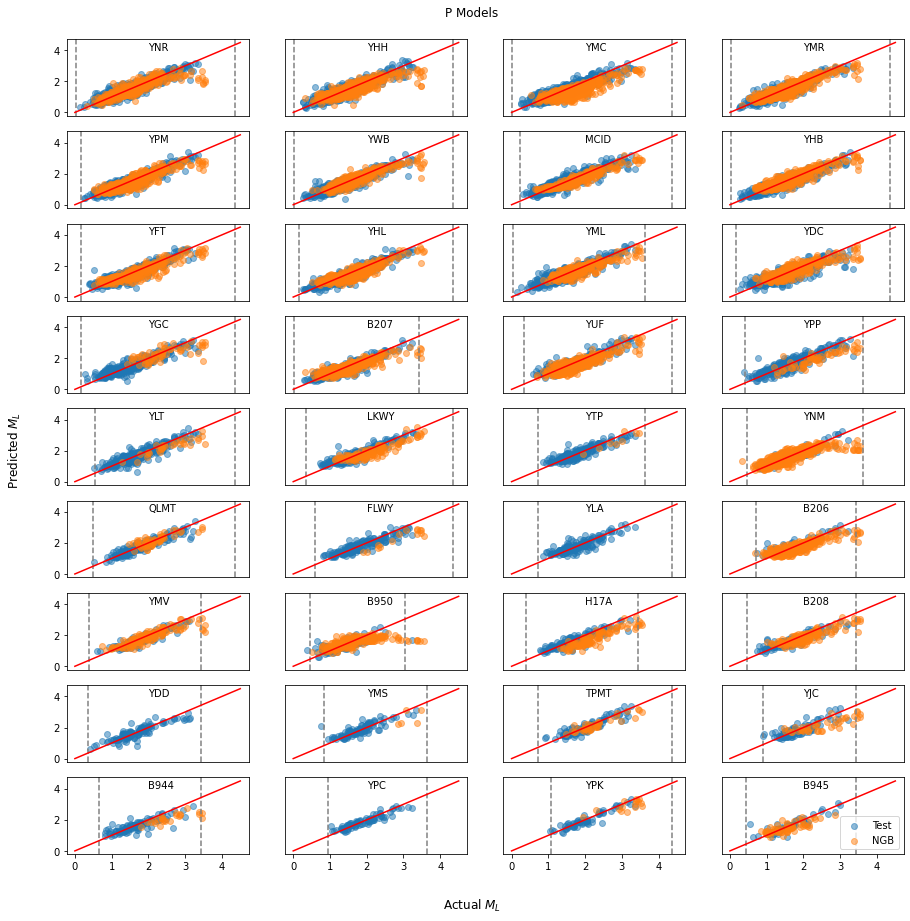

In [21]:
test_size = 0.2

C = 1.0
epsilon=0.1
model_out_path = f"P_magnitude_models_evid_C{C}_e{epsilon}_9features"

if not os.path.exists(model_out_path):
    os.makedirs(model_out_path)

n_stats = (stat_counts.Count > 350).sum()
first_stat = 0

# master evid seperation
evids = np.unique(df_org_filtcounts.event_identifier)
train_evids, test_evids = train_test_split(evids, test_size = test_size, random_state = 843823)

n_cols = 4
n_rows = (n_stats-first_stat)//n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
cnt = 0

stat_results = {}
combined_test_summary = []
combined_ngb_summary = []

for station, ax in zip(stat_counts.iloc[first_stat:n_stats].Station.values, axes.flatten()):
    print("Working on station:", station)
    
    station_df = df_org_filtcounts[df_org_filtcounts.station == station]
#     evids = np.unique(station_df.event_identifier)
#     train_evids, test_evids = train_test_split(evids, test_size = test_size, random_state = 843823)
    
    train_inds = np.isin(station_df.event_identifier, train_evids)
    train_df = station_df[train_inds]
    test_df = station_df[~train_inds]

    train_count = len(train_df)
    test_count = len(test_df)
    
    print(f"{train_count} training examples - {(train_count/len(station_df))*100}%")
    print(f"{test_count} testing examples - {(test_count/len(station_df))*100}%")

#     assert len(train_df.event_identifier.unique()) == len(train_evids)
#     assert len(test_df.event_identifier.unique()) == len(test_evids)
    assert len(test_df) + len(train_df) == len(station_df)

    include_noise_var = False
#     if station == "YMC":
#         include_noise_var = True

    X_train, scaler = compute_feature_df(train_df, scaler=None, include_noise_var=include_noise_var)
    X_test, _ = compute_feature_df(test_df, scaler=scaler, include_noise_var=include_noise_var)
    
    y_train = train_df.magnitude.values
    y_test = test_df.magnitude.values
    
    print("SVR with all features:")
    svr = SVR(C=C, epsilon=epsilon, gamma="scale")
    svr.fit(X_train, y_train)
    
    y_est = svr.predict(X_test)
    train_est = svr.predict(X_train) 
    # Save train information
    train_results = np.concatenate([np.expand_dims(train_df.event_identifier.values, axis=1), 
                                   X_train, np.expand_dims(y_train, axis=1), np.expand_dims(train_est, axis=1)], axis=1)
    train_results_df = pd.DataFrame(train_results, columns=["evid", 'amp_ratio_01.0', 'amp_02.0', 'signal_variance', 'noise_variance', 'noise_max_amplitude', 
         'signal_max_amplitude', 'source_receiver_distance_logkm', 'source_depth_km','receiver_back_azimuth', 
                           "magnitude", "predicted_magnitude"])
    train_results_df["evid"] = train_results_df.evid.astype(int)
    train_results_df.to_csv(f"{model_out_path}/{station}_train_summary_df.csv", index=False)
    
    
    # Save test information 
    test_results = np.concatenate([np.expand_dims(test_df.event_identifier.values, axis=1), 
                                   X_test, np.expand_dims(y_test, axis=1), np.expand_dims(y_est, axis=1)], axis=1)
    test_results_df = pd.DataFrame(test_results, columns=["evid", 'amp_ratio_01.0', 'amp_02.0', 'signal_variance', 'noise_variance', 'noise_max_amplitude', 
         'signal_max_amplitude', 'source_receiver_distance_logkm', 'source_depth_km','receiver_back_azimuth', 
                           "magnitude", "predicted_magnitude"])
    test_results_df["evid"] = test_results_df.evid.astype(int)
    test_results_df.to_csv(f"{model_out_path}/{station}_test_summary_df.csv", index=False)
    
    test_summary = test_df[['event_identifier', 'location_code', 'magnitude', 'magnitude_type',
       'network', 'station']]
    test_summary.loc[:, "predicted_magnitude"] = y_est
    combined_test_summary.append(test_summary)
    ##
    
    test_mse = mean_squared_error(y_test, y_est)
    test_r2 = r2_score(y_test, y_est)
    print("Test MSE", test_mse)
    print("Test R2:", test_r2)
    
    train_mse = mean_squared_error(y_train, train_est)
    train_r2 = r2_score(y_train, train_est)
    print("Train MSE", train_mse)
    print("Train R2:", train_r2)
      
    stat_ngb_df = df_ngb_filtcounts[df_ngb_filtcounts.station==station]
    ngb_count = len(stat_ngb_df)
    ngb_mse = None
    ngb_r2 = None
    if ngb_count > 1:
        print(ngb_count, "NGB examples")
        X_ngb, _ = compute_feature_df(stat_ngb_df, scaler=scaler, include_noise_var=include_noise_var)
        y_ngb = stat_ngb_df.magnitude.values
        ngb_est = svr.predict(X_ngb)
        ngb_mse = mean_squared_error(y_ngb, ngb_est)
        ngb_r2 = r2_score(y_ngb, ngb_est)
        print("NGB MSE", ngb_mse)
        print("NGB R2:", ngb_r2)
        
        NGB_results = np.concatenate([np.expand_dims(stat_ngb_df.event_identifier.values, axis=1), 
                                   X_ngb, np.expand_dims(y_ngb, axis=1), np.expand_dims(ngb_est, axis=1)], axis=1)
        NGB_results_df = pd.DataFrame(NGB_results, columns=["evid", 'amp_ratio_01.0', 'amp_02.0', 'signal_variance', 'noise_variance', 'noise_max_amplitude', 
         'signal_max_amplitude', 'source_receiver_distance_logkm', 'source_depth_km','receiver_back_azimuth', 
                           "magnitude", "predicted_magnitude"])
        NGB_results_df["evid"] = NGB_results_df.evid.astype(int)
        NGB_results_df.to_csv(f"{model_out_path}/{station}_NGB_summary_df.csv", index=False)
        
        ngb_summary = stat_ngb_df[['event_identifier', 'location_code', 'magnitude', 'magnitude_type',
       'network', 'station']]
        ngb_summary.loc[:, "predicted_magnitude"] = ngb_est
        combined_ngb_summary.append(ngb_summary)
    
    joblib.dump(svr, f"{model_out_path}/{station}.SVR.joblib")
    joblib.dump(scaler, f"{model_out_path}/{station}.train.scaler.joblib")
#     np.savetxt(f"{model_out_path}/{station}_train_evids.txt", train_evids)
#     np.savetxt(f"{model_out_path}/{station}_test_evids.txt", test_evids)
    
    stat_results[f"{station}"] = {"test_mse":test_mse, "test_r2":test_r2, "train_mse":train_mse,
                                  "train_r2":train_r2, "ngb_mse":ngb_mse, "ngb_r2":ngb_r2, 
                                  "train_count":train_count, "test_count":test_count, "ngb_count":ngb_count}
#     # Individual plots
#     ind_fig = plt.figure()
#     plt.scatter(y_test, y_est)
#     if ngb_r2 is not None:
#         plt.scatter(y_ngb, ngb_est)
#     plt.plot(range(0, 5), range(0, 5), color="red")
#     plt.xlabel("Actual")
#     plt.ylabel("Predicted")
#     plt.title(station)
#     plt.show()
    
    # Combined plot
    if cnt < n_stats-n_cols:
        ax.set_xticks([])
    if cnt % n_cols != 0:
        ax.set_yticks([])

    ax.scatter(y_test, y_est, label="Test", color="C0", alpha=0.5)
    if ngb_r2 is not None:
        ax.scatter(y_ngb, ngb_est, label="NGB", color="C1", alpha=0.5)
    ax.axvline(np.min(y_train), color="gray", linestyle="--")
    ax.axvline(np.max(y_train), color="gray", linestyle="--")
    ax.plot(np.arange(0, 5, 0.5), np.arange(0, 5, 0.5), color="red")
    ax.text(2.0, 4.0, station) #, bbox={"facecolor":"white", "alpha":0.5})
#     ax.text(-0.05, 4, f"$r^2={test_r2: 0.2f}$", color="C0", bbox={"facecolor":"white", "alpha":0.5})
#     ax.text(-0.05, 3.25, f"$N={test_count}$", color="C0", bbox={"facecolor":"white", "alpha":0.5})
#     ax.text(1.5, 4, f"$r^2={ngb_r2: 0.2f}$", color="C1", bbox={"facecolor":"white", "alpha":0.5})
#     ax.text(1.5, 3.25, f"$N={ngb_count}$", color="C1", bbox={"facecolor":"white", "alpha":0.5})

    cnt += 1

np.savetxt(f"{model_out_path}/train_evids.txt", train_evids)
np.savetxt(f"{model_out_path}/test_evids.txt", test_evids)

results_df = pd.DataFrame(stat_results).transpose()
results_df = results_df.reset_index()
results_df.to_csv(f"{model_out_path}/stat_results_df.csv")

combined_test_summary_df = pd.concat(combined_test_summary)
combined_ngb_summary_df = pd.concat(combined_ngb_summary)

combined_test_summary_df.to_csv(f"{model_out_path}/combined_test_summary_df.csv", index=False)
combined_ngb_summary_df.to_csv(f"{model_out_path}/combined_ngb_summary_df.csv", index=False)

fig.supxlabel(r"Actual $M_L$", y=0.07, fontsize=12)
fig.supylabel(r"Predicted $M_L$", x=0.07, fontsize=12)
#fig.suptitle(f"C={C}, $\epsilon$={epsilon}", y=0.91, fontsize=12)
fig.suptitle("P Models", y=0.91, fontsize=12)
plt.legend(loc="lower right")

In [9]:
eq_meta_all

evid network station location channelz phase  arrival_id  \
0       60000004      UU     HLJ       01      EHZ     P         228   
1       60000004      UU     LDJ       01      EHZ     P         223   
2       60000004      UU     KLJ       01      EHZ     P         233   
3       60000004      UU     HTU       01      EHZ     P         238   
4       60000004      UU     DAU       01      EHZ     P         253   
...          ...     ...     ...      ...      ...   ...         ...   
317117  60507292      UU     NMU       01      EHZ     S     3991659   
317118  60507292      UU    FOR8       01      HHZ     P     3991694   
317119  60507292      UU    FOR1       01      HHZ     P     3991704   
317120  60507292      UU    MTPU       01      HHZ     P     3991874   
317121  60507292      UU    SWUT       01      HHZ     P     3991709   

        arrival_time  pick_quality  first_motion  ...        gain_1  \
0       1.349658e+09          1.00             1  ...           NaN   
1       1.349658e+09          1.00             1  ...           NaN   
2       1.349658e+09          0.75             0  ...           NaN   
3       1.349658e+09          0.50             0  ...           NaN   
4       1.349658e+09          0.50             0  ...           NaN   
...              ...           ...           ...  ...           ...   
317117  1.658997e+09          0.75             0  ...  8.554450e+08   
317118  1.658997e+09          0.50             0  ...  4.810000e+08   
317119  1.658997e+09          0.75             0  ...  4.868606e+08   
317120  1.658997e+09          0.75             0  ...  5.107069e+08   
317121  1.658997e+09          0.75             0  ...  5.107069e+08   

              gain_2  low_freq_corners_1  low_freq_corners_2  \
0                NaN                 NaN                 NaN   
1                NaN                 NaN                 NaN   
2                NaN                 NaN                 NaN   
3                NaN                 NaN                 NaN   
4                NaN                 NaN                 NaN   
...              ...                 ...                 ...   
317117  8.986406e+08                40.0                40.0   
317118  4.810000e+08                80.0                80.0   
317119  4.868606e+08                40.0                40.0   
317120  5.107069e+08                40.0                40.0   
317121  5.107069e+08                40.0                40.0   

        high_freq_corners_1  high_freq_corners_2  channel_dip_1  \
0                       NaN                  NaN            NaN   
1                       NaN                  NaN            NaN   
2                       NaN                  NaN            NaN   
3                       NaN                  NaN            NaN   
4                       NaN                  NaN            NaN   
...                     ...                  ...            ...   
317117             4.204196             4.204196            0.0   
317118             0.008251             0.008251            0.0   
317119             3.550736             3.550736            0.0   
317120             4.204196             4.204196            0.0   
317121             3.564715             3.564715            0.0   

        channel_azimuth_1  channel_dip_2  channel_azimuth_2  
0                     NaN            NaN                NaN  
1                     NaN            NaN                NaN  
2                     NaN            NaN                NaN  
3                     NaN            NaN                NaN  
4                     NaN            NaN                NaN  
...                   ...            ...                ...  
317117                0.0            0.0               90.0  
317118                0.0            0.0               90.0  
317119                0.0            0.0               90.0  
317120                0.0            0.0               90.0  
317121                0.0            0

In [10]:
test_df.head(1)

arrival_identifier  avg_noise_1.00  avg_noise_10.00  avg_noise_11.00  \
31176               46254         0.00052         0.001446          0.00136   

       avg_noise_12.00  avg_noise_13.00  avg_noise_14.00  avg_noise_15.00  \
31176         0.001391         0.001427         0.001421         0.001363   

       avg_noise_16.00  avg_noise_17.00  ...  signal_dominant_frequency  \
31176         0.001267         0.001152  ...                       11.0   

       signal_maximum_value  signal_minimum_value  signal_variance  \
31176              0.517298             -0.387133         0.021831   

       source_depth_km  source_latitude  source_longitude  \
31176            11.06        44.774667       -111.023333   

       source_receiver_back_azimuth  source_receiver_distance_km  station  
31176                    239.109316                    25.756337     B945  

[1 rows x 59 columns]

In [11]:
X_test[0]

array([ 0.60563972, -0.06508772,  0.18125277,  1.05993342,  0.9039877 ,
        0.13341794,  0.23717877,  1.16549423,  0.55372776])

In [12]:
results_df

index  test_mse   test_r2  train_mse  train_r2   ngb_mse    ngb_r2  \
0    YNR  0.041963  0.855423   0.031138  0.899718  0.076894  0.735684   
1    YHH  0.044484  0.848190   0.031804  0.896558  0.080654  0.717668   
2    YMC  0.054360  0.818011   0.049258  0.847538  0.179601  0.387124   
3    YMR  0.044840  0.839800   0.037902  0.877685  0.052906  0.803156   
4    YPM  0.040377  0.858153   0.033407  0.895806  0.061238  0.777086   
5    YWB  0.043204  0.847847   0.028334  0.913795  0.060654  0.787889   
6   MCID  0.045283  0.852038   0.029662  0.905643  0.059938  0.803419   
7    YHB  0.036479  0.880966   0.025106  0.926300  0.061154  0.780517   
8    YFT  0.046338  0.825327   0.037802  0.869969  0.068201  0.793860   
9    YHL  0.039134  0.868358   0.029610  0.908532  0.077806  0.712913   
10   YML  0.049397  0.816129   0.037759  0.872654  0.073631  0.719432   
11   YDC  0.070160  0.754740   0.049006  0.844326  0.081325  0.709018   
12   YGC  0.046579  0.843467   0.027304  0.918227  0.174206  0.467695   
13  B207  0.050594  0.835101   0.036197  0.883332  0.071002  0.722885   
14   YUF  0.056808  0.810816   0.040624  0.861172  0.080080  0.674730   
15   YPP  0.061828  0.808037   0.043035  0.869146  0.224235  0.424242   
16   YLT  0.051378  0.820260   0.038174  0.875544  0.149132  0.531715   
17  LKWY  0.045408  0.836387   0.031890  0.889879  0.090838  0.692889   
18   YTP  0.045047  0.815081   0.033135  0.855956  0.077551  0.654907   
19   YNM  0.043424  0.844847   0.028187  0.916710  0.095321  0.649441   
20  QLMT  0.036796  0.875885   0.016288  0.948452  0.059021  0.664886   
21  FLWY  0.056449  0.812113   0.037948  0.863889  0.389365 -0.190532   
22   YLA  0.056709  0.757552   0.039045  0.837894       NaN       NaN   
23  B206  0.059454  0.738402   0.035952  0.842993  0.081081  0.664961   
24   YMV  0.042373  0.830528   0.027579  0.905135  0.079660  0.764710   
25  B950  0.112196  0.541660   0.032983  0.862923  0.152081  0.407201   
26  H17A  0.053872  0.809369   0.045444  0.858082  0.225329  0.246589   
27  B208  0.060243  0.780204   0.040893  0.841183  0.101131  0.652174   
28   YDD  0.058645  0.789088   0.032533  0.872191       NaN       NaN   
29   YMS  0.064054  0.697543   0.027900  0.873621  0.399964 -5.722534   
30  TPMT  0.047818  0.835055   0.026530  0.910349  0.061834  0.771550   
31   YJC  0.065698  0.698650   0.039591  0.845237  0.247436  0.357328   
32  B944  0.075895  0.692700   0.065664  0.749355  0.334863 -0.504504   
33   YPC  0.033338  0.862827   0.027719  0.884871       NaN       NaN   
34   YPK  0.033104  0.891931   0.028809  0.917153  0.130384  0.333968   
35  B945  0.063078  0.788546   0.016020  0.954159  0.070316  0.604715   

    train_count  test_count  ngb_count  
0        3621.0       884.0      512.0  
1        3496.0       855.0      656.0  
2        3209.0       783.0      459.0  
3        2881.0       690.0      667.0  
4        2904.0       701.0      596.0  
5        2778.0       679.0      398.0  
6        2697.0       702.0      315.0  
7        2513.0       620.0      521.0  
8        2591.0       657.0      390.0  
9        2438.0       615.0      368.0  
10       2440.0       583.0      293.0  
11       2258.0       551.0      345.0  
12       1700.0       414.0       62.0  
13       1228.0       290.0      471.0  
14       1097.0       274.0      413.0  
15       1300.0       315.0       58.0  
16       1235.0       300.0       32.0  
17        923.0       229.0      142.0  
18        862.0       222.0        8.0  
19        408.0       107.0      546.0  
20        739.0       183.0       60.0  
21        678.0       178.0       15.0  
22        676.0       174.0        1.0  
23        385.0       102.0      359.0  
24        445.0       111.0      147.0  
25        306.0        79.0      306.0  
26        444.0       119.0      106.0  
27        406.0       107.0      147.0  
28        493.0       121.0        0.0  
29        407.0       103.0        5.0  
30        372.0        93.0   

(0.0, 1.0)

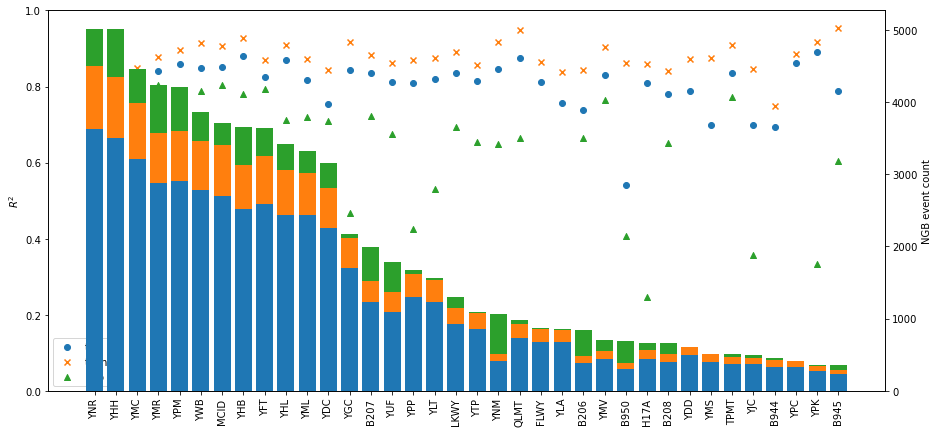

In [13]:
from collections import OrderedDict
fig = plt.figure(1, figsize=(15, 7))

x_range = range(first_stat, n_stats)
for ind in x_range:
    stat = stat_counts.iloc[ind].Station
    plt.scatter(ind, stat_results[stat]["test_r2"], label="test", marker="o", color="C0")
    plt.scatter(ind, stat_results[stat]["train_r2"], label="train", marker="x", color="C1")
    
    ngb_r2 = stat_results[stat]["ngb_r2"]
    if ngb_r2 is not None and ngb_r2 < 0:
        ngb_r2 = 0
    plt.scatter(ind, ngb_r2, label="ngb", marker="^", color="C2")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower left")

ax1 = plt.gca()
ax1.set_xticks(x_range, labels=stat_counts.iloc[first_stat:n_stats].Station.values, rotation="vertical");
ax2 = ax1.twinx()

ax2.bar(x_range, results_df.train_count, label="train")
ax2.bar(x_range, results_df.test_count, bottom=results_df.train_count)
ax2.bar(x_range, results_df.ngb_count, bottom=results_df.train_count+results_df.test_count)

ax2.set_ylabel("NGB event count")
ax1.set_ylabel(r"$R^2$")
ax1.set_ylim([0, 1.0])

(0.0, 1.0)

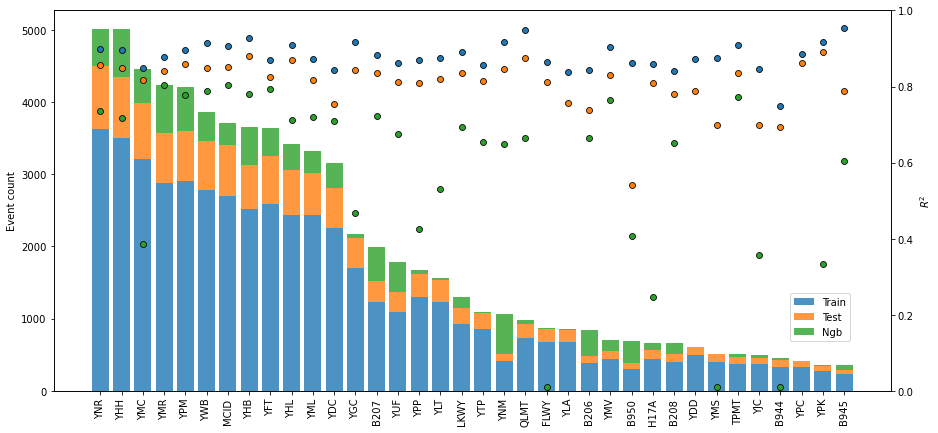

In [14]:
from collections import OrderedDict
fig = plt.figure(1, figsize=(15, 7))

x_range = range(first_stat, n_stats)

plt.bar(x_range, results_df.train_count, label="Train", alpha=0.8)
plt.bar(x_range, results_df.test_count, bottom=results_df.train_count, label="Test", alpha=0.8)
plt.bar(x_range, results_df.ngb_count, bottom=results_df.train_count+results_df.test_count, label="Ngb", alpha=0.8)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc=(0.88, 0.13))

ax1 = plt.gca()
ax1.set_xticks(x_range, labels=results_df["index"], rotation="vertical");
ax2 = ax1.twinx()

plt.scatter(x_range, results_df.train_r2, label="train", marker="o", color="C0", edgecolor="k", linewidth=0.8)
plt.scatter(x_range, results_df.test_r2, label="test", marker="o", color="C1", edgecolor="k", linewidth=0.8)

ngb_r2 = results_df["ngb_r2"].copy()
ngb_r2[ngb_r2 < 0] = 0.01

plt.scatter(x_range, ngb_r2, label="ngb", marker="o", color="C2", edgecolor="k", linewidth=0.8)

ax1.set_ylabel("Event count")
ax2.set_ylabel(r"$R^2$")
ax2.set_ylim([0, 1.0])

(0.0, 1.0)

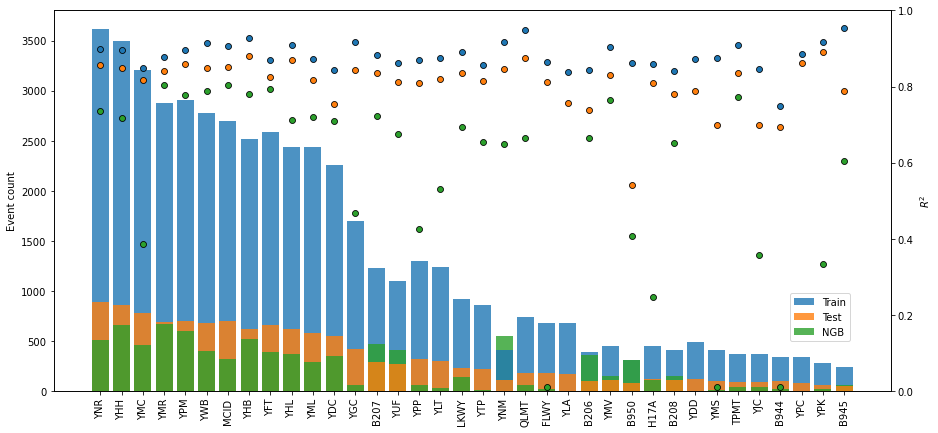

In [15]:
from collections import OrderedDict
fig = plt.figure(1, figsize=(15, 7))

x_range = range(first_stat, n_stats)

color_dict = {"train_count":"C0", "test_count":"C1", "ngb_count":"C2"}
label_dict = {"train_count":"Train", "test_count":"Test", "ngb_count":"NGB"}

for ind in range(len(results_df["index"])):
    stat = results_df.index[ind]
    counts = results_df.loc[stat][["test_count", "train_count", "ngb_count"]].sort_values(ascending=False)
    plt.bar(ind, counts.iloc[0], label=label_dict[counts.index[0]], alpha=0.8, color=color_dict[counts.index[0]])
    plt.bar(ind, counts.iloc[1], label=label_dict[counts.index[1]], alpha=0.8, color=color_dict[counts.index[1]])
    plt.bar(ind, counts.iloc[2], label=label_dict[counts.index[2]], alpha=0.8, color=color_dict[counts.index[2]])

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc=(0.88, 0.13))

ax1 = plt.gca()
ax1.set_xticks(x_range, labels=results_df["index"], rotation="vertical");
ax2 = ax1.twinx()

plt.scatter(x_range, results_df.train_r2, label="train", marker="o", color="C0", edgecolor="k", linewidth=0.8)
plt.scatter(x_range, results_df.test_r2, label="test", marker="o", color="C1", edgecolor="k", linewidth=0.8)

ngb_r2 = results_df["ngb_r2"].copy()
ngb_r2[ngb_r2 < 0] = 0.01

plt.scatter(x_range, ngb_r2, label="ngb", marker="o", color="C2", edgecolor="k", linewidth=0.8)

ax1.set_ylabel("Event count")
ax2.set_ylabel(r"$R^2$")
ax2.set_ylim([0, 1.0])